<h2><center>Training Pre-Trained BERT for Sentiment Analysis</center></h2>


<center><h3>Assignment 5</h3><h4>Part 2</h4></center>

Name: Soham Biswas

Roll No: MDS202147

Email ID: sohamb@cmi.ac.in

#### Importing the required packages

In [1]:
import os, sys, random
import datetime, time, copy
import torch, warnings

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import transformers

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from PIL import Image

warnings.filterwarnings("ignore")
%matplotlib inline

#### Setting the directory of the data

In [2]:
data = "/kaggle/input/tweet-text-classification-data/tweet_data"

##### Checking if Cuda is available

In [3]:
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

Using GPU:  True


##### Setting Random Seed

In [4]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

##### Loading the training data

In [5]:
full_train_list = [(i.split(',')[-1], int(i.split(',')[0])//2) 
              for i in open(data + "/train_data.csv", errors='replace').readlines() 
              if len(i.split(',')[0]) == 1]

random.shuffle(full_train_list)

train_per = 0.6
val_per = 0.25
train_num = int(train_per*len(full_train_list))
val_num = int(val_per*len(full_train_list))

train_list, val_list, test_list = full_train_list[:train_num], full_train_list[train_num:train_num+val_num], full_train_list[train_num+val_num:]

len(train_list), len(val_list), len(test_list)

(629143, 262143, 157286)

##### Seperating Text and Labels

In [6]:
train_x, train_y = [i[0] for i in train_list], [i[1] for i in train_list]
val_x, val_y = [i[0] for i in val_list], [i[1] for i in val_list]
test_x, test_y = [i[0] for i in test_list], [i[1] for i in test_list]

##### Loading Bert Model and Tokenizer

In [7]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for pos/neu/neg classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# BERT Uncased Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

##### Visualizing the lengths of sentences

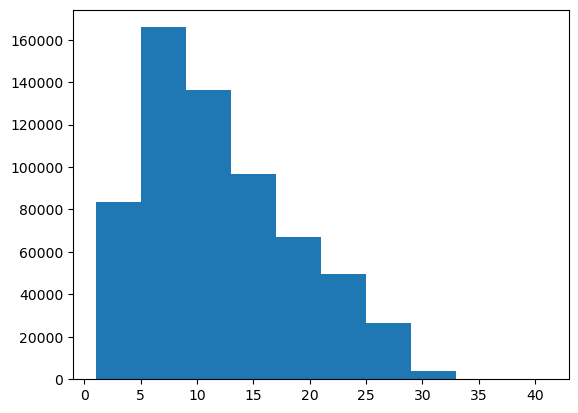

In [8]:
seq_len = [len(i.split()) for i in train_x]

plt.hist(seq_len)
plt.show()

##### Padding with length 30 and tokenizing all texts

In [9]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_x,
    max_length = 30,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_x,
    max_length = 30,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_x,
    max_length = 30,
    padding='max_length',
    truncation=True
)

##### Converting Sequences, Attention Masks to Tensors

In [10]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_y)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_y)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_y)

##### Creating DataLoader objects

In [11]:
batch_size = 32

# Warping, sampling the training data and creating dataLoader object
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Warping, sampling the validation data and creating dataLoader object
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

##### Printing the Model to look under the hood

In [12]:
model.to(device)
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

##### The last 'classifier' layer has been intiated with un-trained weights

##### Defining optimizer parameters for training

In [13]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


##### Scheduler parameters for training

In [14]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

##### Defining a helper function

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

##### Training

In [16]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear Gradients
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss, logits = output.loss, output.logits

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss, logits = output.loss, output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  19,661.    Elapsed: 0:00:14.
  Batch   200  of  19,661.    Elapsed: 0:00:26.
  Batch   300  of  19,661.    Elapsed: 0:00:38.
  Batch   400  of  19,661.    Elapsed: 0:00:50.
  Batch   500  of  19,661.    Elapsed: 0:01:02.
  Batch   600  of  19,661.    Elapsed: 0:01:15.
  Batch   700  of  19,661.    Elapsed: 0:01:27.
  Batch   800  of  19,661.    Elapsed: 0:01:39.
  Batch   900  of  19,661.    Elapsed: 0:01:51.
  Batch 1,000  of  19,661.    Elapsed: 0:02:03.
  Batch 1,100  of  19,661.    Elapsed: 0:02:15.
  Batch 1,200  of  19,661.    Elapsed: 0:02:27.
  Batch 1,300  of  19,661.    Elapsed: 0:02:40.
  Batch 1,400  of  19,661.    Elapsed: 0:02:52.
  Batch 1,500  of  19,661.    Elapsed: 0:03:04.
  Batch 1,600  of  19,661.    Elapsed: 0:03:16.
  Batch 1,700  of  19,661.    Elapsed: 0:03:28.
  Batch 1,800  of  19,661.    Elapsed: 0:03:40.
  Batch 1,900  of  19,661.    Elapsed: 0:03:53.
  Batch 2,000  of  19,661.    Elapsed: 0:04:0

##### Saving the fine-tuned model

In [17]:
trained_model = copy.deepcopy(model)
torch.save(trained_model, os.path.join('fine_tuned_bert_model' + '.t7'))